In [2]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

imgL = cv2.imread('./src/view0.png', 0)
imgR = cv2.imread('./src/view1.png', 0)

### Original Images

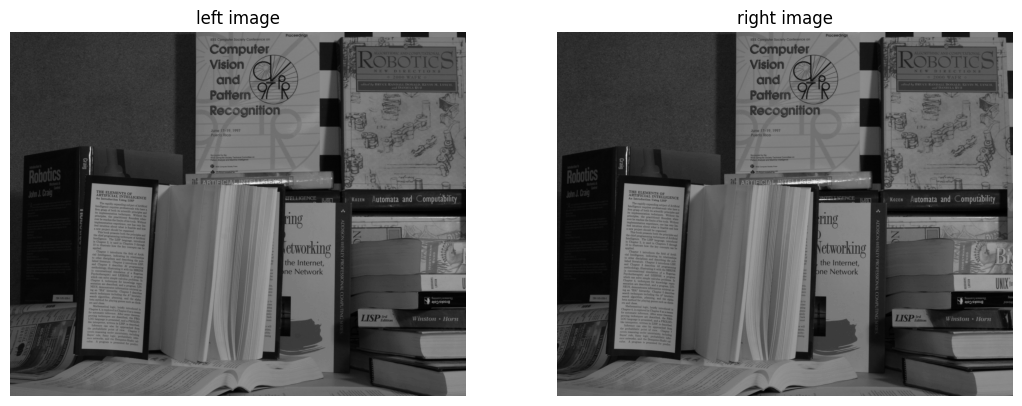

In [3]:
pylab.figure(figsize=(20, 10)),pylab.gray()

pylab.subplot (2, 3, 1), pylab.imshow(imgL)
pylab.title('left image'), pylab.axis('off')
pylab.subplot (2, 3, 2), pylab.imshow(imgR)
pylab.title('right image'), pylab.axis('off')
pylab.subplots_adjust (wspace=0.2, hspace=0)
pylab.show()

### Block Matching

time : 0.0039479732513427734


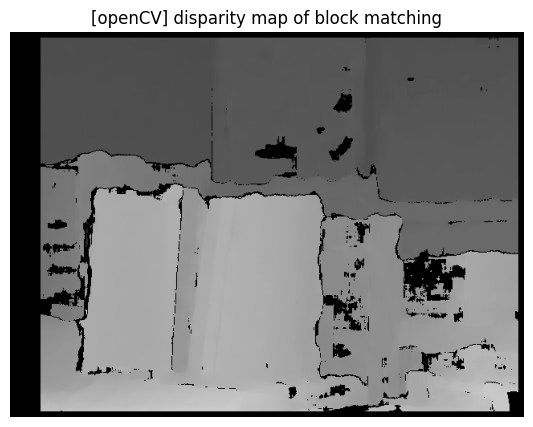

In [130]:
start = time.time()  # 시작 시간 저장

stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
disparity = stereo.compute(imgL,imgR)

print("time :", time.time() - start)
pylab.figure(figsize=(10, 5)), pylab.axis('off')
pylab.imshow(disparity,'gray'), pylab.title('[openCV] disparity map of block matching')
pylab.show()

time : 0.003782033920288086


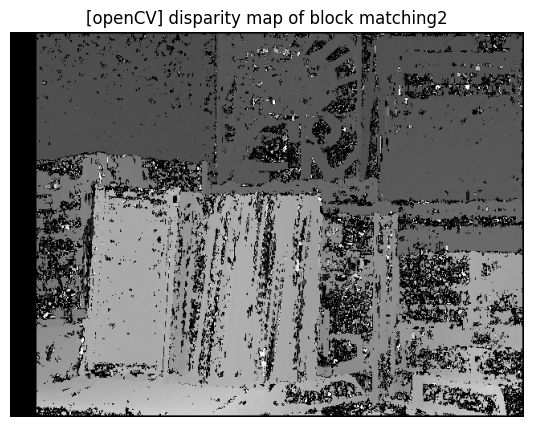

In [140]:
start = time.time()  # 시작 시간 저장

stereo = cv2.StereoBM_create(numDisparities=32, blockSize=5)
disparity = stereo.compute(imgL,imgR)

print("time :", time.time() - start)
pylab.figure(figsize=(10, 5)), pylab.axis('off')
pylab.imshow(disparity,'gray'), pylab.title('[openCV] disparity map of block matching2')
pylab.show()

### Semi Global Block Matching

time : 0.02252507209777832


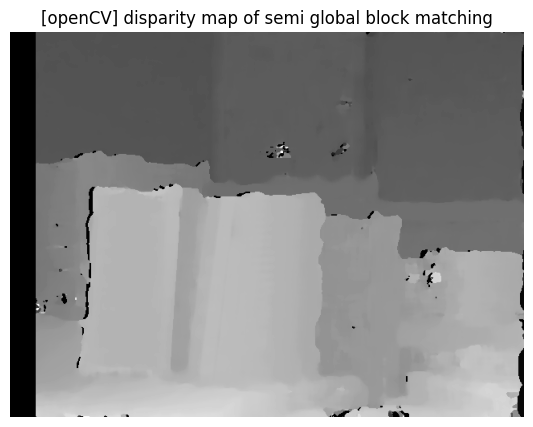

In [157]:
start = time.time()  # 시작 시간 저장

stereo = cv2.StereoSGBM_create(numDisparities=32, blockSize=15)
disparity = stereo.compute(imgL,imgR)

print("time :", time.time() - start)
pylab.figure(figsize=(10, 5))
pylab.imshow(disparity,'gray'), pylab.axis('off'), pylab.title('[openCV] disparity map of semi global block matching')
pylab.show()

### Semi Global Block Matching + Filter

In [158]:
def depth_map(imgL, imgR):
    """ Depth map calculation. Works with SGBM and WLS. Need rectified images, returns depth map ( left to right disparity ) """
    # SGBM Parameters -----------------
    window_size = 3  # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely

    left_matcher = cv2.StereoSGBM_create(
        minDisparity=-1,
        numDisparities=5*16,  # max_disp has to be dividable by 16 f. E. HH 192, 256
        blockSize=window_size,
        P1=8 * 3 * window_size,
        # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
        P2=32 * 3 * window_size,
        disp12MaxDiff=12,
        uniquenessRatio=10,
        speckleWindowSize=50,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    # FILTER Parameters
    lmbda = 80000
    sigma = 1.3
    visual_multiplier = 6

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)

    wls_filter.setSigmaColor(sigma)
    displ = left_matcher.compute(imgL, imgR)  # .astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!

    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    filteredImg = np.uint8(filteredImg)

    return filteredImg

time : 0.03403496742248535


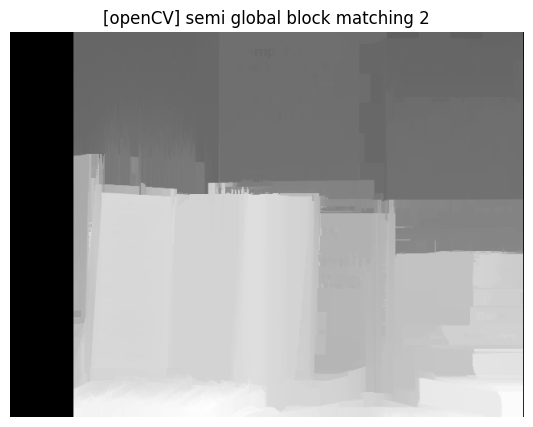

In [159]:
start = time.time()  # 시작 시간 저장

sgbm2 = depth_map(imgL, imgR)
print("time :", time.time() - start)
pylab.figure(figsize=(10, 5))
pylab.imshow(sgbm2,'gray'), pylab.axis('off'), pylab.title('[openCV] semi global block matching 2')
pylab.show()

### Disparity Map 추출

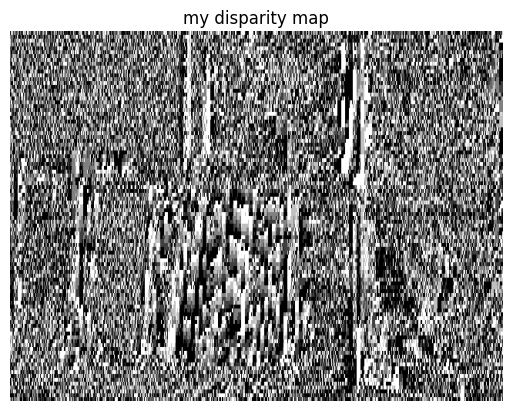

time : 0.18087410926818848


In [160]:
start = time.time()  # 시작 시간 저장

blockSize = 5
numDisparities = 4
# 지연 매칭 알고리즘을 사용하여 지연 매핑을 찾습니다.
disparity_map = np.zeros_like(imgL)
for x in range(0, imgL.shape[1], blockSize):
  for y in range(0, imgL.shape[0], blockSize):
    
    # 왼쪽 이미지의 블록과 오른쪽 이미지의 블록을 가져옵니다.
    blockL = imgL[y:y + blockSize, x:x + blockSize]
    blockR = imgR[y:y + blockSize, x:x + blockSize]
    
    # 왼쪽 이미지의 각 픽셀에 대해 가장 일치하는 픽셀을 찾습니다.
    bestMatchX = np.argmin(np.abs(blockL - blockR), axis=1)

    # 현재 픽셀의 지연 값을 설정합니다.
    disparity_map[y:y + blockSize, x:x + blockSize] = np.clip(bestMatchX, 0, numDisparities)

# 지연 매핑을 표시합니다.
plt.imshow(disparity_map, cmap="gray")
plt.axis('off'), plt.title('my disparity map')
plt.show()
print("time :", time.time() - start)

/var/folders/d2/bg4kwmb169d3d8vt2frh2bsh0000gp/T/ipykernel_6760/1111750343.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = gray_img.resize((640, 480), Image.ANTIALIAS)


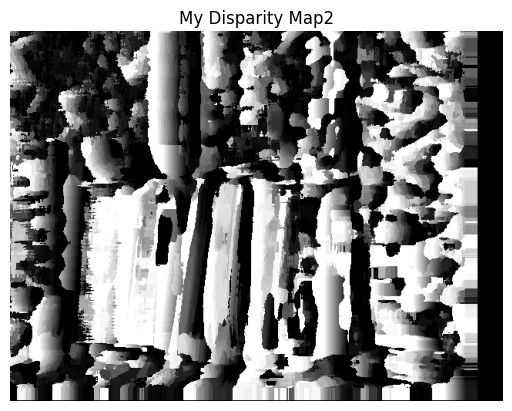

time : 31.326688051223755


In [161]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def image_preprocessing(img_path):
    img = Image.open(img_path)
    gray_img = img.convert('L')  
    resized_img = gray_img.resize((640, 480), Image.ANTIALIAS)
    return np.array(resized_img)  

def compute_disparity_map(imgL, imgR, blockSize, numDisparities):
    disparity_map = np.zeros_like(imgL)

    for y in range(0, imgL.shape[0] - blockSize):
        for x in range(0, imgL.shape[1] - blockSize - numDisparities):
            blockL = imgL[y:y + blockSize, x:x + blockSize]
            block_diff = np.zeros(numDisparities)

            for d in range(numDisparities):
                blockR = imgR[y:y + blockSize, x+d:x + blockSize + d]
                block_diff[d] = np.sum(np.abs(blockL - blockR))

            bestMatchIdx = np.argmin(block_diff)
            disparity_map[y:y + blockSize, x:x + blockSize] = bestMatchIdx

    return disparity_map

imgL = image_preprocessing('./src/view0.png')
imgR = image_preprocessing('./src/view1.png')
start = time.time()  # 시작 시간 저장

blockSize = 16
numDisparities = blockSize * 2
disparity_map = compute_disparity_map(imgL, imgR, blockSize, numDisparities)

plt.imshow(disparity_map, cmap="gray")
plt.axis('off')
plt.title('My Disparity Map2')
plt.show()
print("time :", time.time() - start)